# 第八章 &nbsp; &nbsp; Attention
上一章我们使用 RNN 生成了文本，又通过连接两个 RNN，将一个时序数据转换为了另一个时序数据。我们将这个网络称为 seq2seq，并用它成功求解了简单的加法问题。之后，我们对这个 seq2seq 进行了几处改进，几乎完美地解决了这个简单的加法问题。

本章我们将进一步探索 seq2seq 的可能性（以及 RNN 的可能性）。这里，Attention 这一强大而优美的技术将登场。Attention 毫无疑问是近年来深度学习领域最重要的技术之一。本章的目标是在代码层面理解 Attention 的结构，然后将其应用于实际问题，体验它的奇妙效果。

## Attention的结构
如上一章所述，seq2seq 是一个非常强大的框架，应用面很广。这里我们将介绍进一步强化 seq2seq 的**注意力机制**（attention mechanism，简称 Attention）。基于 Attention 机制，seq2seq 可以像我们人类一样，将 “注意力” 集中在必要的信息上。此外，使用 Attention 可以解决当前 seq2seq 面临的问题。

本节我们将首先指出当前 seq2seq 存在的问题，然后一边说明 Attention 的结构，一边对其进行实现。

上一章我们已经对seq2seq进行了改进，但那些只能算是“小改进”。下面将要说明的Attention技术才是解决seq2seq的问题的“大改进”。

## seq2seq存在的问题
seq2seq 中使用编码器对时序数据进行编码，然后将编码信息传递给解码器。此时，编码器的输出是固定长度的向量。实际上，这个 “固定长度” 存在很大问题。因为固定长度的向量意味着，无论输入语句的长度如何（无论多长），都会被转换为长度相同的向量。以上一章的翻译为例，如图所示，不管输入的文本如何，都需要将其塞入一个固定长度的向量中。

<img src="./fig/encoder.png" alt="encoder" style="display: block; margin: 0 auto;">

无论多长的文本，当前的编码器都会将其转换为固定长度的向量。就像把一大堆西装塞入衣柜里一样，编码器强行把信息塞入固定长度的向量中。但是，这样做早晚会遇到瓶颈。就像最终西装会从衣柜中掉出来一样，有用的信息也会从向量中溢出。

现在我们就来改进 seq2seq。首先改进编码器，然后再改进解码器。

## 编码器的改进1
到目前为止，我们都只将 LSTM 层的最后的隐藏状态传递给解码器，但是编码器的输出的长度应该根据输入文本的长度相应地改变。这是编码器的一个可以改进的地方。具体而言，如图所示，使用各个时刻的 LSTM 层的隐藏状态。

<img src="./fig/encoder_all_time.png" alt="encoder_all_time" style="display: block; margin: 0 auto;">

如图所示，使用各个时刻（各个单词）的隐藏状态向量，可以获得和输入的单词数相同数量的向量。在图中的例子中，输入了 5 个单词，此时编码器输出 5 个向量。这样一来，编码器就摆脱了 “一个固定长度的向量” 的制约。

在许多深度学习框架中，在初始化RNN层（或者LSTM层、GRU层等）时，可以选择是返回“全部时刻的隐藏状态向量”，还是返回“最后时刻的隐藏状态向量”。比如，在Keras中，在初始化RNN层时，可以设置 <code>return_sequences</code> 为True或者False。

上图中我们需要关注 LSTM 层的隐藏状态的 “内容”。此时，各个时刻的 LSTM 层的隐藏状态都充满了什么信息呢？有一点可以确定的是，各个时刻的隐藏状态中包含了大量当前时刻的输入单词的信息。就图中的例子来说，输入 “猫” 时的 LSTM 层的输出（隐藏状态）受此时输入的单词 “猫” 的影响最大。因此，可以认为这个隐藏状态向量蕴含许多 “猫的成分”。按照这样的理解，如图所示，编码器输出的 $\boldsymbol{h}\boldsymbol{s}$ 矩阵就可以视为各个单词对应的向量集合。

<img src="./fig/encoder_hs.png" alt="encoder_hs" style="display: block; margin: 0 auto;">

因为编码器是从左向右处理的，所以严格来说，刚才的“猫”向量中含有“吾輩”“は”“猫”这3个单词的信息。考虑整体的平衡性，最好均衡地含有单词“猫”周围的信息。在这种情况下，从两个方向处理时序数据的双向RNN（或者双向LSTM）比较有效。我们后面再介绍双向RNN，这里先继续使用单向LSTM。

以上就是对编码器的改进。这里我们所做的改进只是将编码器的全部时刻的隐藏状态取出来而已。通过这个小改动，编码器可以根据输入语句的长度，成比例地编码信息。那么，解码器又将如何处理这个编码器的输出呢？接下来，我们对解码器进行改进。因为解码器的改进有许多值得讨论的地方，所以我们分 3 部分进行。

## 解码器的改进
编码器整体输出各个单词对应的 LSTM 层的隐藏状态向量 $\boldsymbol{h}\boldsymbol{s}$。然后，这个 $\boldsymbol{h}\boldsymbol{s}$ 被传递给解码器，以进行时间序列的转换。

<img src="./fig/relation.png" alt="relation" style="display: block; margin: 0 auto;">

顺便说一下，在上一章的最简单的 seq2seq 中，仅将编码器最后的隐藏状态向量传递给了解码器。严格来说，这是将编码器的 LSTM 层的 “最后” 的隐藏状态放入了解码器的 LSTM 层的 “最初” 的隐藏状态。用图来表示的话，解码器的层结构如图所示。

<img src="./fig/decoder_before.png" alt="decoder_before" style="display: block; margin: 0 auto;">

如图所示，上一章的解码器只用了编码器的 LSTM 层的最后的隐藏状态。如果使用 $\boldsymbol{h}\boldsymbol{s}$，则只提取最后一行，再将其传递给解码器。下面我们改进解码器，以便能够使用全部 $\boldsymbol{h}\boldsymbol{s}$。

我们在进行翻译时，大脑做了什么呢？比如，在将 “吾輩は猫である” 这句话翻译为英文时，肯定要用到诸如 “吾輩 = I”“猫 = cat” 这样的知识。也就是说，可以认为我们是专注于某个单词（或者单词集合），随时对这个单词进行转换的。那么，我们可以在 seq2seq 中重现同样的事情吗？确切地说，我们可以让 seq2seq 学习 “输入和输出中哪些单词与哪些单词有关” 这样的对应关系吗？

在机器翻译的历史中，很多研究都利用“猫=cat”这样的单词对应关系的知识。这样的表示单词（或者词组）对应关系的信息称为<strong>对齐</strong>（alignment）。到目前为止，对齐主要是手工完成的，而我们将要介绍的 Attention 技术则成功地将对齐思想自动引入到了 seq2seq 中。这也是从“手工操作”到“机械自动化”的演变。

从现在开始，我们的目标是找出与 “翻译目标词” 有对应关系的 “翻译源词” 的信息，然后利用这个信息进行翻译。也就是说，我们的目标是仅关注必要的信息，并根据该信息进行时序转换。这个机制称为 Attention，是本章的主题。

在介绍 Attention 的细节之前，这里我们先给出它的整体框架。我们要实现的网络的层结构如下图所示。

<img src="./fig/decoder_after.png" alt="decoder_after" style="display: block; margin: 0 auto;">

如图所示，我们新增一个进行 “某种计算” 的层。这个 “某种计算” 接收（解码器）各个时刻的 LSTM 层的隐藏状态和编码器的 $\boldsymbol{h}\boldsymbol{s}$。然后，从中选出必要的信息，并输出到 Affine 层。与之前一样，编码器的最后的隐藏状态向量传递给解码器最初的 LSTM 层。

上图中的网络所做的工作是提取单词对齐信息。具体来说，就是从 $\boldsymbol{h}\boldsymbol{s}$ 中选出与各个时刻解码器输出的单词有对应关系的单词向量。比如，当解码器输出 “I” 时，从 $\boldsymbol{h}\boldsymbol{s}$ 中选出 “吾輩” 的对应向量。也就是说，我们希望通过 “某种计算” 来实现这种选择操作。不过这里有个问题，就是选择（从多个事物中选取若干个）这一操作是无法进行微分的。

神经网络的学习一般通过误差反向传播法进行。因此，如果使用可微分的运算构造网络，就可以在误差反向传播法的框架内进行学习；而如果不使用可微分的运算，基本上也就没有办法使用误差反向传播法。

可否将 “选择” 这一操作换成可微分的运算呢？实际上，解决这个问题的思路很简单（但是，就像哥伦布蛋一样，第一个想到是很难的）。这个思路就是，与其 “单选”，不如 “全选”。如下图所示，我们另行计算表示各个单词重要度（贡献值）的权重。

<img src="./fig/word_weight.png" alt="word_weight" style="display: block; margin: 0 auto;">

如图所示，这里使用了表示各个单词重要度的权重（记为 $\boldsymbol{a}$）。此时，$\boldsymbol{a}$ 像概率分布一样，各元素是 0.0 ~ 1.0 的标量，总和是 1。然后，计算这个表示各个单词重要度的权重和单词向量 $\boldsymbol{h}\boldsymbol{s}$ 的加权和，可以获得目标向量。这一系列计算如下图所示。

<img src="./fig/weight_addition.png" alt="weight_addition" style="display: block; margin: 0 auto;">

如图所示，计算单词向量的加权和，这里将结果称为上下文向量，并用符号 $\boldsymbol{c}$ 表示。顺便说一下，如果我们仔细观察，就可以发现 “吾輩” 对应的权重为 0.8。这意味着上下文向量 $\boldsymbol{c}$ 中含有很多 “吾輩” 向量的成分，可以说这个加权和计算基本代替了 “选择” 向量的操作。假设 “吾輩” 对应的权重是 1，其他单词对应的权重是 0，那么这就相当于 “选择” 了 “吾輩” 向量。

上下文向量 $\boldsymbol{c}$ 中包含了当前时刻进行变换（翻译）所需的信息。更确切地说，模型要从数据中学习出这种能力。

下面，我们从代码的角度来看一下目前为止的内容。这里随意地生成编码器的输出 $\boldsymbol{h}\boldsymbol{s}$ 和各个单词的权重 $\boldsymbol{a}$，并给出求它们的加权和的实现，代码如下所示，请注意多维数组的形状。

In [1]:
import numpy as np

T, H = 5, 4 # T: 时间步数, H: 隐藏状态向量的元素个数
hs = np.random.rand(T, H) # 隐藏状态向量
print(hs.shape) # (5, 4)

a = np.array([0.8, 0.1, 0.03, 0.05, 0.02]) # 注意力权重
print(a.shape) # (5,)

ar = a.reshape(5, 1).repeat(4, axis=1) # repeat表示沿着指定轴复制元素，这里按照列方向复制4次
print(ar.shape) # (5, 4)
print(ar) # [[0.8 0.8 0.8 0.8] [0.1 0.1 0.1 0.1] [0.03 0.03 0.03 0.03] [0.05 0.05 0.05 0.05] [0.02 0.02 0.02 0.02]]

t = hs * ar # 广播机制，对应元素相乘
print(t.shape) # (5, 4)

c = np.sum(t, axis=0) # 按行求和
print(c.shape) # (4,)
print(c) 

(5, 4)
(5,)
(5, 4)
[[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.03 0.03 0.03 0.03]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]]
(5, 4)
(4,)
[0.90783898 0.22390136 0.66314289 0.76434554]


设时序数据的长度 $T=5$，隐藏状态向量的元素个数 $H=4$，这里给出了加权和的计算过程。我们先关注代码 $ar = a.reshape(5, 1).repeat(4, axis=1)$。如图 8-9 所示，这行代码将 $a$ 转化为 $ar$。

<img src="./fig/reshape_and_repeat.png" alt="reshape_and_repeat" style="display: block; margin: 0 auto;">

如图所示，我们要做的是复制形状为 `(5,)` 的 `a`，创建 `(5,4)` 的数组。因此，通过 `a.reshape(5, 1)` 将 `a` 的形状从 `(5,)` 转化为 `(5,1)`。然后，在第 1 个轴方向上（`axis=0`）重复这个变形后的数组 4 次，生成形状为 `(5,4)` 的数组。

`repeat()` 方法复制多维数组的元素生成新的多维数组。设 `x` 为 NumPy 多维数组，则可以像 `x.repeat(rep, axis)` 这样使用。这里参数 `rep` 指定复制的次数，`axis` 指定要进行复制的轴（维度）。比如，在 `x` 的形状为 `(X, Y, Z)` 的情况下，`x.repeat(3, axis=1)` 沿 `x` 的第 1 个轴方向（第 1 个维度）进行复制，生成形状为 `(X, 3*Y, Z)` 的多维数组。

此外，这里也可以不使用 `repeat()` 方法，而使用 NumPy 的广播功能。此时，令 `ar = a.reshape(5, 1)`，然后计算 `hs * ar`。如下图所示，`ar` 会自动扩展以匹配 `hs` 的形状。

<img src="./fig/numpy_broadcast.png" alt="numpy_broadcast" style="display: block; margin: 0 auto;">

为了提高执行效率，这里应该使用 NumPy 的广播，而不是 `repeat()` 方法。但是，在这种情况下，需要注意的是，在许多我们看不见的地方多维数组的元素被复制了。由之前的小节可知，这相当于计算图中的 Repeat 节点。因此，在反向传播时，需要执行 Repeat 节点的反向传播。

如上图所示，先计算对应元素的乘积，然后通过 `c = np.sum(hs*ar, axis=0)` 求和。这里，通过参数 `axis` 可以指定在哪个轴方向（维度）上求和。如果我们注意一下数组的形状，`axis` 的使用方法就会很清楚。比如，当 `x` 的形状为 `(X, Y, Z)` 时，`np.sum(x, axis=1)` 的输出（和）的形状为 `(X, Z)`。这里的重点是，求和会使一个轴 “消失”。在上面的例子中，`hs*ar` 的形状为 `(5,4)`，通过消除第 0 个轴，获得了形状为 `(4,)` 的矩阵（向量）。

计算加权和最简单有效的方法是使用矩阵乘积。就上面的例子来说，只需要 `np.dot(a, hs)` 这一行代码就可以获得目标结果。不过，这样只能处理一笔数据（样本），很难将其扩展到批处理。如果非要扩展，就需要用到 “张量积”，这会使事情变得有些复杂（在这种情况下，需要使用 `np.tensordot()` 和 `np.einsum()` 方法）。简单起见，这里我们不使用矩阵乘积，而是通过 `repeat()` 和 `sum()` 方法来实现加权和的计算。

下面进行批处理版的加权和的实现，具体如下所示（这里随机创建 `hs` 和 `a`）。

In [2]:
N, T, H = 10, 5, 4 # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数
hs = np.random.rand(N, T, H) # 隐藏状态向量
print(hs.shape) # (10, 5, 4)

a = np.random.rand(N, T) # 注意力权重
print(a.shape) # (10, 5)

ar = a.reshape(N, T, 1).repeat(H, axis=2) # repeat表示沿着指定轴复制元素，这里按照列方向复制4次
# ar = a.reshape(N, T, 1) # 也可以不使用repeat，利用numpy的广播机制
print(ar.shape) # (10, 5, 4)

t = hs * ar # 广播机制，对应元素相乘
print(t.shape) # (10, 5, 4)

c = np.sum(t, axis=1) # 按行求和
print(c.shape) # (10, 4)
print(c)

(10, 5, 4)
(10, 5)
(10, 5, 4)
(10, 5, 4)
(10, 4)
[[1.01195067 1.03986192 1.40571894 1.64116333]
 [1.9763091  2.02767884 1.92690147 1.53661538]
 [1.51998232 1.13553073 1.51037607 1.21680207]
 [1.04276072 1.09254412 1.12593429 0.7116679 ]
 [1.8692966  1.47513212 1.42634727 1.71139373]
 [1.59130503 1.53944015 1.06293276 0.94520264]
 [0.5376699  0.71093776 0.69754462 0.72074355]
 [1.20785944 0.99786316 0.64943048 0.56494925]
 [1.88658035 1.12246527 2.68473801 2.40732741]
 [0.73441817 1.0343341  1.93592002 1.8492881 ]]


这里的批处理与之前的实现几乎一样。只要注意数组的形状，应该很快就能确定 `repeat()` 和 `sum()` 需要指定的维度（轴）。作为总结，我们把加权和的计算用计算图表示出来。

<img src="./fig/addition_example.png" alt="addition_example" style="display: block; margin: 0 auto;">

如图所示，这里使用 Repeat 节点复制 $a$。之后，通过 “$\times$” 节点计算对应元素的乘积，通过 Sum 节点求和。现在考虑这个计算图的反向传播。其实，所需要的知识都已经齐备。第 1 章介绍了 Repeat 节点和 Sum 节点的反向传播。这里重述一下要点：“Repeat 的反向传播是 Sum”“Sum 的反向传播是 Repeat”。只要注意到张量的形状，就不难知道应该对哪个轴进行 Sum，对哪个轴进行 Repeat。

现在我们将上图的计算图实现为层，这里称之为 Weight Sum 层，其实现如下所示。

In [3]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数

        ar = a.reshape(N, T, 1).repeat(H, axis=2) # repeat表示沿着指定轴复制元素，这里按照列方向复制H次
        t = hs * ar # 广播机制，对应元素相乘
        c = np.sum(t, axis=1) # 按行求和

        self.cache = (hs, ar) # 反向传播时使用
        return c

    def backward(self, dc):
        hs, ar = self.cache # 从前向传播中取得缓存数据
        N, T, H = hs.shape # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数
        dt = dc.reshape(N, 1, H).repeat(T, axis=1) # dc的维度为(N, H)，需要变形为(N, T, H)才能与hs和ar对应
        dar = dt * hs # 广播机制，对应元素相乘
        dhs = dt * ar # 广播机制，对应元素相乘
        da = np.sum(dar, axis=2) # 按列求和

        return dhs, da

以上就是计算上下文向量的 Weight Sum 层的实现。因为这个层没有要学习的参数，所以根据本书的代码规范，此处为 `self.params = []`。其他应该没有特别难的地方，我们继续往下看。

## 解码器的改进2
有了表示各个单词重要度的权重 $\boldsymbol{a}$，就可以通过加权和获得上下文向量。那么，怎么求这个 $\boldsymbol{a}$ 呢？当然不需要我们手动指定，我们只需要做好让模型从数据中自动学习它的准备工作。

下面我们来看一下各个单词的权重 $\boldsymbol{a}$ 的求解方法。首先，从编码器的处理开始到解码器第一个 LSTM 层输出隐藏状态向量的处理为止的流程如下图所示。

<img src="./fig/decoder_first_LSTM.png" alt="decoder_first_LSTM" style="display: block; margin: 0 auto;">

在图中，用 $\boldsymbol{h}$ 表示解码器的 LSTM 层的隐藏状态向量。此时，我们的目标是用数值表示这个 $\boldsymbol{h}$ 在多大程度上和 $\boldsymbol{h}\boldsymbol{s}$ 的各个单词向量 “相似”。有几种方法可以做到这一点，这里我们使用最简单的向量内积。顺便说一下，向量 $\boldsymbol{a} = (a_1, a_2, \cdots, a_n)$ 和向量 $\boldsymbol{b} = (b_1, b_2, \cdots, b_n)$ 的内积为：

$$
\boldsymbol{a} \cdot \boldsymbol{b} = a_1b_1 + a_2b_2 + \cdots + a_nb_n \tag{8.1}
$$

式 (8.1) 的含义是两个向量在多大程度上指向同一方向，因此使用内积作为两个向量的 “相似度” 是非常自然的选择。

计算向量相似度的方法有好几种。除了内积之外，还有使用小型的神经网络输出得分的做法。

下面用图表示基于内积计算向量间相似度的处理流程。

<img src="./fig/dot.png" alt="dot" style="display: block; margin: 0 auto;">

如图所示，这里通过向量内积算出 $\boldsymbol{h}$ 和 $\boldsymbol{h}\boldsymbol{s}$ 的各个单词向量之间的相似度，并将其结果表示为 $\boldsymbol{s}$。不过，这个 $\boldsymbol{s}$ 是正规化之前的值，也称为得分。接下来，使用老一套的 Softmax 函数对 $\boldsymbol{s}$ 进行正规化。

<img src="./fig/softmax.png" alt="softmax" style="display: block; margin: 0 auto;">

使用 Softmax 函数之后，输出的 $\boldsymbol{a}$ 的各个元素的值在 $0.0 \sim 1.0$，总和为 1，这样就求得了表示各个单词权重的 $\boldsymbol{a}$。现在我们从代码角度来看一下这些处理。

In [4]:
import sys
sys.path.append('..') # 为了导入父目录的common模块
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4 # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数
hs = np.random.rand(N, T, H) # 隐藏状态向量
print(hs) # (10, 5, 4)

h = np.random.rand(N, H) # 查询向量
print(h) # (10, 4)

hr = h.reshape(N, 1, H).repeat(T, axis=1) # repeat表示沿着指定轴复制元素，这里按照列方向复制T次
# hr = h.reshape(N, 1, H) # 也可以不使用repeat，利用numpy的广播机制
print(hr) # (10, 1, 4)

t = hs * hr # 广播机制，对应元素相乘
print(t) # (10, 5, 4)

s = np.sum(t, axis=2) # 按列求和
print(s) # (10, 5)

softmax = Softmax()
a = softmax.forward(s) # 注意力权重
print(a) # (10, 5)

[[[0.77695449 0.37656654 0.48170621 0.75729175]
  [0.47520998 0.56609887 0.87964318 0.22298534]
  [0.59360664 0.30738468 0.88985671 0.5849681 ]
  [0.61770363 0.69425839 0.51242927 0.57657531]
  [0.27941957 0.48287317 0.73900374 0.91587326]]

 [[0.79169181 0.31080077 0.51583566 0.10707723]
  [0.29762806 0.25016266 0.07091503 0.69747741]
  [0.61309348 0.46432729 0.60393699 0.39676065]
  [0.7068785  0.71073355 0.23905607 0.13281973]
  [0.71315434 0.58240203 0.69902012 0.14540145]]

 [[0.40068604 0.23516233 0.63518692 0.55852045]
  [0.01397556 0.86549137 0.57917183 0.96483811]
  [0.46597886 0.71403315 0.3532388  0.82671019]
  [0.08069756 0.97821932 0.57290961 0.58462479]
  [0.75509924 0.00599862 0.17637129 0.71280269]]

 [[0.616761   0.70684457 0.9244903  0.40323676]
  [0.48433328 0.31320464 0.39397085 0.30806484]
  [0.2963989  0.66071022 0.02993041 0.29550522]
  [0.77730622 0.8892604  0.4248498  0.98874528]
  [0.66546474 0.5303415  0.85028522 0.66064458]]

 [[0.85278191 0.68876347 0.79835

以上就是进行批处理的代码。如前所述，此处我们通过 `reshape()` 和 `repeat()` 方法生成形状合适的 `hr`。在使用 NumPy 的广播的情况下，不需要 `repeat()`。此时的计算图如下图所示。

<img src="./fig/word_weight_image.png" alt="word_weight_image" style="display: block; margin: 0 auto;">

如图所示，这里的计算图由 Repeat 节点、表示对应元素的乘积的 “$\times$” 节点、Sum 节点和 Softmax 层构成。我们将这个计算图表示的处理实现为 `AttentionWeight` 类。

In [5]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数

        hr = h.reshape(N, 1, H).repeat(T, axis=1) # repeat表示沿着指定轴复制元素，这里按照列方向复制T次
        t = hs * hr # 广播机制，对应元素相乘
        s = np.sum(t, axis=2) # 按列求和
        a = self.softmax.forward(s) # 注意力权重

        self.cache = (hs, hr) # 反向传播时使用
        return a

    def backward(self, da):
        hs, hr = self.cache # 从前向传播中取得缓存数据
        N, T, H = hs.shape # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数

        ds = self.softmax.backward(da) # 形状为(N, T)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2) # 形状为(N, T, H)
        dhs = dt * hr # 广播机制，对应元素相乘
        dhr = dt * hs # 广播机制，对应元素相乘
        dh = np.sum(dhr, axis=1) # 按行求和，形状为(N, H)

        return dhs, dh

类似于之前的 Weight Sum 层，这个实现有 Repeat 和 Sum 运算。只要注意到这两个运算的反向传播，其他应该就没有特别难的地方。下面，我们进行解码器的最后一个改进。

## 解码器的改进3
在此之前，我们分两节介绍了解码器的改进方案。之前的小节分别实现了 Weight Sum 层和 Attention Weight 层。现在，我们将这两层组合起来，结果如下图所示。

<img src="./fig/context_vector.png" alt="context_vector" style="display: block; margin: 0 auto;">

上图显示了用于获取上下文向量 $\boldsymbol{c}$ 的计算图的全貌。我们已经分为 Weight Sum 层和 Attention Weight 层进行了实现。重申一下，这里进行的计算是：Attention Weight 层关注编码器输出的各个单词向量 $\boldsymbol{h}\boldsymbol{s}$，并计算各个单词的权重 $\boldsymbol{a}$；然后，Weight Sum 层计算 $\boldsymbol{a}$ 和 $\boldsymbol{h}\boldsymbol{s}$ 的加权和，并输出上下文向量 $\boldsymbol{c}$。我们将进行这一系列计算的层称为 Attention 层。

<img src="./fig/attention_layer.png" alt="attention_layer" style="display: block; margin: 0 auto;">

以上就是 Attention 技术的核心内容。关注编码器传递的信息 $\boldsymbol{h}\boldsymbol{s}$ 中的重要元素，基于它算出上下文向量，再传递给上一层（这里，Affine 层在上一层等待）。下面给出 Attention 层的实现。

In [6]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight() # 注意力权重层
        self.weight_sum_layer = WeightSum() # 加权和层
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h) # 注意力权重
        out = self.weight_sum_layer.forward(hs, a) # 上下文向量
        self.attention_weight = a # 保存注意力权重，供外部使用
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout) # 反向传播到加权和层
        dhs1, dh = self.attention_weight_layer.backward(da) # 反向传播到注意力权重层
        dhs = dhs0 + dhs1 # 加权和层和注意力权重层的梯度相加
        return dhs, dh

以上是 Weight Sum 层和 Attention Weight 层的正向传播和反向传播。为了以后可以访问各个单词的权重，这里设定成员变量 `attention_weight`，如此就完成了 Attention 层的实现。我们将这个 Attention 层放在 LSTM 层和 Affine 层的中间，如图所示。

<img src="./fig/attention.png" alt="attention" style="display: block; margin: 0 auto;">

如图所示，编码器的输出 $\boldsymbol{h}\boldsymbol{s}$ 被输入到各个时刻的 Attention 层。另外，这里将 LSTM 层的隐藏状态向量输入 Affine 层。根据上一章的解码器的改进，可以说这个扩展非常自然。如下图所示，我们将 Attention 信息 “添加” 到了上一章的解码器上。

<img src="./fig/attention_LSTM.png" alt="attention_LSTM" style="display: block; margin: 0 auto;">

如图所示，我们向上一章的解码器 “添加” 基于 Attention 层的上下文向量信息。因此，除了将原先的 LSTM 层的隐藏状态向量传给 Affine 层之外，追加输入 Attention 层的上下文向量。

在图中，上下文向量和隐藏状态向量这两个向量被输入 Affine 层。如前所述，这意味着将这两个向量拼接起来，将拼接后的向量输入 Affine 层。

最后，我们将时序方向上扩展的多个 Attention 层整体实现为 Time Attention 层，如下图所示。

<img src="./fig/time_attention.png" alt="time_attention" style="display: block; margin: 0 auto;">

由图可知，Time Attention 层只是组合了多个 Attention 层，其实现如下所示。

In [7]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数
        out = np.empty_like(hs_dec) # 输出的形状与 hs_dec 相同
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention() # 每个时间步一个 Attention 层
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:]) # 计算 t 时刻的输出
            self.layers.append(layer) # 保存层，供反向传播使用
            self.attention_weights.append(layer.attention_weight) # 保存注意力权重

        return out

    def backward(self, dout):
        N, T, H = dout.shape # N: 批量大小, T: 时间步数, H: 隐藏状态向量的元素个数
        dhs_enc = 0 # 编码器隐藏状态的梯度
        dhs_dec = np.empty_like(dout) # 解码器隐藏状态的梯度

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

这里仅创建必要数量的 Attention 层（代码中为 T 个），各自进行正向传播和反向传播。另外，`attention_weights` 列表中保存了各个 Attention 层对各个单词的权重。

以上，我们介绍了 Attention 的结构及其实现。下面我们使用 Attention 来实现 seq2seq，并尝试挑战一个真实问题，以确认 Attention 的效果。

## 带 Attention 的 seq2seq 的实现
上一节实现了 Attention 层（以及 Time Attention 层），现在我们使用这个层来实现 “带 Attention 的 seq2seq”。和上一章实现了 3 个类（`Encoder`、`Decoder` 和 `seq2seq`）一样，这里我们也分别实现 3 个类（`AttentionEncoder`、`AttentionDecoder` 和 `AttentionSeq2seq`）。

## 编码器的实现
首先实现 `AttentionEncoder` 类。这个类和上一章实现的 `Encoder` 类几乎一样，唯一的区别是，`Encoder` 类的 `forward()` 方法仅返回 LSTM 层的最后的隐藏状态向量，而 `AttentionEncoder` 类则返回所有的隐藏状态向量。因此，这里我们继承上一章的 `Encoder` 类进行实现。`AttentionEncoder` 类的实现如下所示。

In [8]:
import sys
sys.path.append('..') # 为了导入父目录的common模块
from common.time_layers import *
from seq2seq import Encoder, Seq2seq
from attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## 解码器的实现
接着实现使用了 Attention 层的解码器。使用了 Attention 的解码器的层结构如图所示。

<img src="./fig/decoder_layer.png" alt="decoder_layer" style="display: block; margin: 0 auto;">

从图中可以看出，和上一章的实现一样，Softmax 层（更确切地说，是 Time Softmax with Loss 层）之前的层都作为解码器。另外，和上一章一样，除了正向传播 `forward()` 方法和反向传播 `backward()` 方法之外，还实现了生成新单词序列（字符序列）的 `generate()` 方法。这里仅给出 Attention Decoder 层的初始化方法和 `forward()` 方法的实现，如下所示。

In [9]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词汇表大小, 词向量维度, 隐藏状态向量的元素个数
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # 词向量
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # LSTM的输入权重
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # LSTM的隐藏状态权重
        lstm_b = np.zeros(4 * H).astype('f') # LSTM的偏置
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f') # 输出层的权重
        affine_b = np.zeros(V).astype('f') # 输出层的偏置

        self.embed = TimeEmbedding(embed_W) # 词嵌入层
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True) # LSTM层
        self.attention = TimeAttention() # 注意力层
        self.affine = TimeAffine(affine_W, affine_b) # 全连接层
        layers = [self.embed, self.lstm, self.attention, self.affine] # 顺序存储各层

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs): # xs: 解码器输入，维度为(N, T), enc_hs: 编码器隐藏状态，维度为(N, T_enc, H)
        h = enc_hs[:,-1] # 取编码器隐藏状态的最后一个时间步
        self.lstm.set_state(h) # 设置LSTM的初始隐藏状态

        out = self.embed.forward(xs) # 词嵌入
        dec_hs = self.lstm.forward(out) # 解码器隐藏状态
        c = self.attention.forward(enc_hs, dec_hs) # 上下文向量
        out = np.concatenate((c, dec_hs), axis=2) # 连接上下文向量和解码器隐藏状态
        score = self.affine.forward(out) # 计算得分

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore) # 反向传播到全连接层
        N, T, H2 = dout.shape # N: 批量大小, T: 时间步数, H2: 2*隐藏状态向量的元素个数
        H = H2 // 2 # 隐藏状态向量的元素个数

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:] # 分离上下文向量和解码器隐藏状态的梯度
        denc_hs, ddec_hs1 = self.attention.backward(dc) # 反向传播到注意力层
        ddec_hs = ddec_hs0 + ddec_hs1 # 解码器隐藏状态的梯度
        dout = self.lstm.backward(ddec_hs) # 反向传播到LSTM层
        dh = self.lstm.dh # LSTM的初始隐藏状态的梯度
        denc_hs[:, -1] += dh # 编码器隐藏状态的最后一个时间步的梯度加上LSTM初始隐藏状态的梯度
        self.embed.backward(dout) # 反向传播到词嵌入层

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id # 初始输入的单词ID
        h = enc_hs[:, -1] # 取编码器隐藏状态的最后一个时间步
        self.lstm.set_state(h) # 设置LSTM的初始隐藏状态

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1)) # 当前时间步的输入，维度为(1, 1)

            out = self.embed.forward(x) # 词嵌入
            dec_hs = self.lstm.forward(out) # 解码器隐藏状态
            c = self.attention.forward(enc_hs, dec_hs) # 上下文向量
            out = np.concatenate((c, dec_hs), axis=2) # 连接上下文向量和解码器隐藏状态
            score = self.affine.forward(out) # 计算得分

            sample_id = np.argmax(score.flatten()) # 得分最高的单词ID
            sampled.append(sample_id) # 保存采样结果

        return sampled

这里的实现除使用了新的 Time Attention 层之外，和上一章的 `Decoder` 类没有什么太大的不同。需要注意的是，`forward()` 方法中拼接了 Time Attention 层的输出和 LSTM 层的输出。在上面的代码中，使用 `np.concatenate()` 方法进行拼接。

这里省略对 `AttentionDecoder` 类的 `backward()` 和 `generate()` 方法的说明。最后，我们使用 `AttentionEncoder` 类和 `AttentionDecoder` 类来实现 `AttentionSeq2seq` 类。

## seq2seq 的实现
`AttentionSeq2seq` 类的实现也和上一章实现的 `seq2seq` 几乎一样。区别仅在于，编码器使用 `AttentionEncoder` 类，解码器使用 `AttentionDecoder` 类。因此，只要继承上一章的 `Seq2seq` 类，并改一下初始化方法，就可以实现 `AttentionSeq2seq` 类。

In [10]:
import sys
sys.path.append('..') # 为了导入父目录的模块
from seq2seq import Encoder, Seq2seq

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size # 词汇表大小, 词向量维度, 隐藏状态向量的元素个数
        self.encoder = AttentionEncoder(*args) # 编码器
        self.decoder = AttentionDecoder(*args) # 解码器
        self.softmax = TimeSoftmaxWithLoss() # 损失层

        self.params = self.encoder.params + self.decoder.params # 编码器和解码器的所有参数
        self.grads = self.encoder.grads + self.decoder.grads # 编码器和解码器的所有梯度

## Attention 的评价
下面，我们使用上一节实现的 `AttentionSeq2seq` 类来挑战一个实际问题。原本我们应该通过研究翻译问题来确认 Attention 的效果，可惜没能找到大小适中的翻译数据集。因此，我们转而通过研究 “日期格式转换” 问题（本质上属于人为创造的问题，数据量有限），来确认带 Attention 的 seq2seq 的效果。

WMT 是一个有名的翻译数据集。这个数据集中提供了英语和法语（或者英语和德语）的平行学习数据。WMT 数据集在许多研究中都被作为基准使用，经常用于评价 seq2seq 的性能，不过它的数据量很大（超过 20 GB），使用起来不是很方便。

## 日期格式转换问题
这里我们要处理的是日期格式转换问题。这个任务旨在将使用英语的国家和地区所使用的各种各样的日期格式转换为标准格式。例如，将人写的 “september 27, 1994” 这样的日期数据转换为 “1994-09-27” 这样的标准格式，如下图所示。

<img src="./fig/date_transform.png" alt="date_transform" style="display: block; margin: 0 auto;">

这里采用日期格式转换问题的原因有两个。首先，该问题并不像看上去那么简单。因为输入的日期数据存在各种各样的版本，所以转换规则也相应地复杂。如果尝试将这些转换规则全部写出来，那将非常费力。

其次，该问题的输入（问句）和输出（回答）存在明显的对应关系。具体而言，存在年月日的对应关系。因此，我们可以确认 Attention 有没有正确地关注各自的对应元素。

我们事先在 `dataset/date.txt` 中准备好了要处理的日期转换数据。如图所示，这个文本文件包含 50 000 个日期转换用的学习数据。

<img src="./fig/date_learning.png" alt="date_learning" style="display: block; margin: 0 auto;">

为了对齐输入语句的长度，本书提供的日期数据集填充了空格，并将 “_”（下划线）设置为输入和输出的分隔符。另外，因为这个问题输出的字符数是恒定的，所以无须使用分隔符来指示输出的结束。

如上一章所述，本书提供了一个可以轻松处理上述 seq2seq 用的学习数据的 Python 模块，这个模块位于 <code>dataset/sequence.py</code> 中。

## 带 Attention 的 seq2seq 的学习
下面，我们在日期转换用的数据集上进行 `AttentionSeq2seq` 的学习，学习用的代码如下所示。

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 6[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 13[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 20[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 26[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 33[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 39[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 45[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 52[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 58[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 65[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 73[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 81[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 88[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 96[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 104[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 111[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 119[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
X 1978

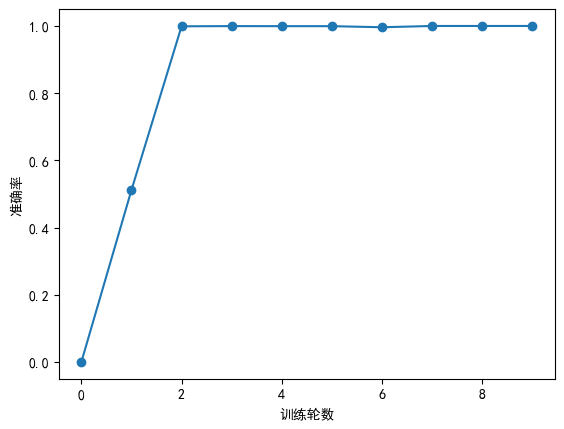

In [11]:
import sys
sys.path.append('..') # 为了导入父目录的common模块
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq
import warnings
warnings.simplefilter('ignore') # 忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 读入数据
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt') # x: 输入语句, t: 目标语句
char_to_id, id_to_char = sequence.get_vocab() # 字符与ID的映射

# 反转输入语句
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # 反转输入语句有助于提升性能

# 设定超参数
vocab_size = len(char_to_id) # 词汇表大小
wordvec_size = 16 # 词向量维度
hidden_size = 256 # 隐藏状态向量的元素个数
batch_size = 128 # 批量大小
max_epoch = 10 # 最大训练轮数
max_grad = 5.0 # 用于梯度裁剪

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam() # Adam优化器
trainer = Trainer(model, optimizer) # 训练器

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad) # 训练1轮

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # 取出一个样本
        verbose = i < 10 # 前10个样本打印推理结果
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True) # 计算正确数量

    acc = float(correct_num) / len(x_test) # 计算准确率
    acc_list.append(acc)
    print('验证集准确率 %.3f%%' % (acc * 100))


model.save_params() # 保存模型参数

# 绘制图形
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('训练轮数')
plt.ylabel('准确率')
plt.ylim(-0.05, 1.05)
plt.show()

这里显示的代码和上一章的加法问题的学习用代码几乎一样。区别在于，它读入日期数据作为学习数据，使用 `AttentionSeq2seq` 作为模型。另外，这里还使用了反转输入语句的技巧（Reverse）。之后，在学习的同时，每个 `epoch` 使用测试数据计算正确率。为了查看结果，我们将前 10 个问题的问句和回答输出到终端。

现在我们运行一下上面的代码。随着学习的进行，结果如图所示。

<img src="./fig/result.png" alt="result" style="display: block; margin: 0 auto;">

如图所示，随着学习的深入，带 Attention 的 seq2seq 变聪明了。实际上，没过多久，它就对大多数问题给出了正确答案。此时，测试数据的正确率（代码中的 `acc_list`）如下图所示。

<img src="./fig/correct_change.png" alt="correct_change" style="display: block; margin: 0 auto;">

如图所示，从第 1 个 `epoch` 开始，正确率迅速上升，到第 2 个 `epoch` 时，几乎可以正确回答所有问题。这可以说是一个很好的结果。我们将这个结果与上一章的模型比较一下，如下图所示。

<img src="./fig/compare.png" alt="compare" style="display: block; margin: 0 auto;">

从上图的结果可知，简单的 seq2seq（图中的 baseline）完全没法用。即使经过了 10 个 `epoch`，大多数问题还是不能回答正确。而使用了 “偷窥” 技术的 Peeky 给出了良好的结果，从第 3 个 `epoch` 开始，模型的正确率开始上升，在第 4 个 `epoch` 时，正确率达到了 100%。但是，就学习速度而言，Attention 稍微有些优势。

在这次的实验中，就最终精度来看，Attention 和 Peeky 取得了差不多的结果。但是，随着时序数据变长、变复杂，除了学习速度之外，Attention 在精度上也会变得更有优势。

## Attention 的可视化
接下来，我们对 Attention 进行可视化。在进行时序转换时，实际观察 Attention 在注意哪个元素。因为在 Attention 层中，各个时刻的 Attention 权重均保存到了成员变量中，所以我们可以轻松地进行可视化。

在我们的实现中，Time Attention 层中的成员变量 `attention_weights` 保存了各个时刻的 Attention 权重，据此可以将输入语句和输出语句的各个单词的对应关系绘制成一张二维地图。这里，我们针对学习好的 `AttentionSeq2seq`，对进行日期格式转换时的 Attention 权重进行可视化。此处，我们不给出代码，仅将结果显示在图上。

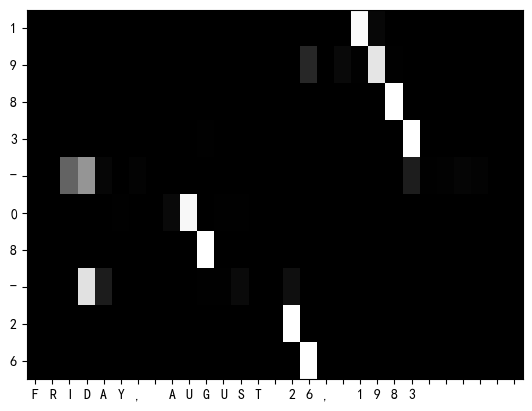

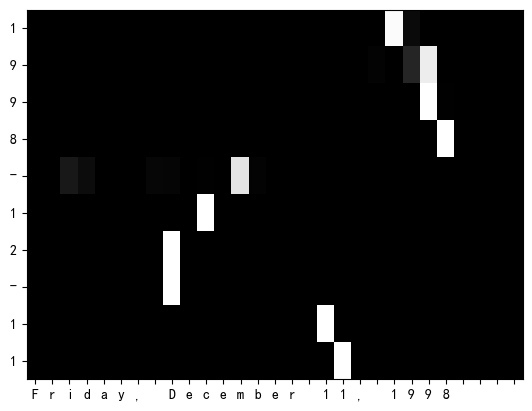

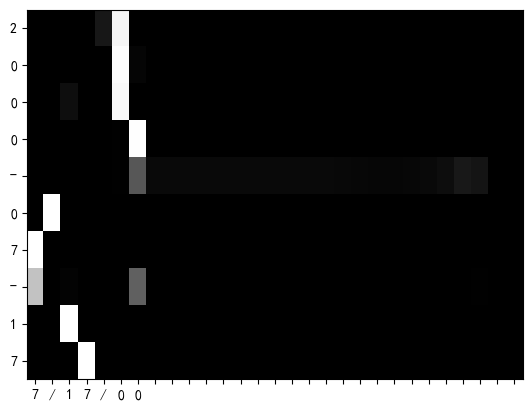

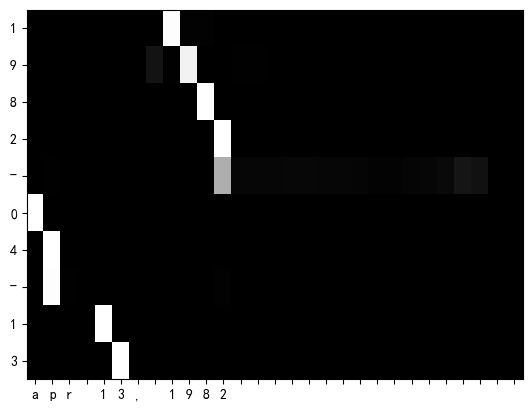

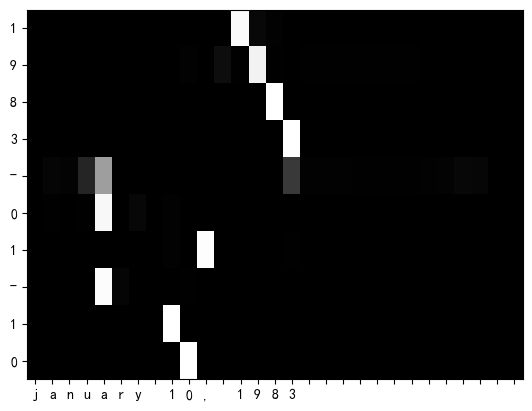

In [12]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
from attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

<img src="./fig/attention_model.png" alt="attention_model" style="display: block; margin: 0 auto;">

上图是 seq2seq 进行时序转换时的 Attention 权重的可视化结果。例如，我们可以看到，当 seq2seq 输出第 1 个 “1” 时，注意力集中在输入语句的 “1” 上。这里需要特别注意年月日的对应关系。仔细观察图中的结果，纵轴（输出）的 “1983” 和 “26” 恰好对应于横轴（输入）的 “1983” 和 “26”。另外，输入语句的 “AUGUST” 对应于表示月份的 “08”，这一点也很令人惊讶。这表明 seq2seq 从数据中学习到了 “August” 和 “8 月” 的对应关系。下图中给出了其他一些例子，从中也可以很清楚地看到年月日的对应关系。

<img src="./fig/attention_weight_example.png" alt="attention_weight_example" style="display: block; margin: 0 auto;">

像这样，使用 Attention，seq2seq 能像我们人一样将注意力集中在必要的信息上。换言之，借助 Attention，我们理解了模型是如何工作的。

我们没有办法理解神经网络内部进行了什么工作（基于何种逻辑工作），而 Attention 赋予了模型 “人类可以理解的结构和意义”。在上面的例子中，通过 Attention，我们看到了单词和单词之间的关联性。由此，我们可以判断模型的工作逻辑是否符合人类的逻辑。

以上就是关于 Attention 的评价的内容。通过这里的实验，我们体验了 Attention 的奇妙效果。至此，Attention 的核心话题就要告一段落了，但是关于 Attention 的其他内容还有不少。下一节我们继续围绕 Attention，介绍它的几个高级技巧。

## 关于 Attention 的其他话题
到目前为止，我们研究了 Attention（正确地说，是带 Attention 的 seq2seq），本节我们介绍几个之前未涉及的话题。

## 双向 RNN
这里我们关注 seq2seq 的编码器。首先复习一下，上一节之前的编码器如图所示。

<img src="./fig/LSTM_hs.png" alt="LSTM_hs" style="display: block; margin: 0 auto;">

如图所示，LSTM 中各个时刻的隐藏状态向量被整合为 $\boldsymbol{h}\boldsymbol{s}$。这里，编码器输出的 $\boldsymbol{h}\boldsymbol{s}$ 的各行中含有许多对应单词的成分。

需要注意的是，我们是从左向右阅读句子的。因此，在图中，单词 “猫” 的对应向量编码了 “吾輩”“は”“猫” 这 3 个单词的信息。如果考虑整体的平衡性，我们希望向量能更均衡地包含单词 “猫” 周围的信息。

在这次的翻译问题中，我们获得了所有的时序数据（需要翻译的文本）。因此，我们既可以从左向右读取文本，也可以从右向左读取文本。

为此，可以让 LSTM 从两个方向进行处理，这就是名为 **双向 LSTM** 的技术，如下图所示。

<img src="./fig/biLSTM.png" alt="biLSTM" style="display: block; margin: 0 auto;">

如图所示，双向 LSTM 在之前的 LSTM 层上添加了一个反方向处理的 LSTM 层。然后，拼接各个时刻的两个 LSTM 层的隐藏状态，将其作为最后的隐藏状态向量（除了拼接之外，也可以 “求和” 或者 “取平均” 等）。

通过这样的双向处理，各个单词对应的隐藏状态向量可以从左右两个方向聚集信息。这样一来，这些向量就编码了更均衡的信息。

双向 LSTM 的实现非常简单。一种实现方式是准备两个 LSTM 层（本章中是 Time LSTM 层），并调整输入各个层的单词的排列。具体而言，其中一个层的输入语句与之前相同，这相当于从左向右处理输入语句的常规的 LSTM 层。而另一个 LSTM 层的输入语句则按照从右到左的顺序输入。如果原文是 “A B C D”，就改为 “D C B A”。通过输入改变了顺序的输入语句，另一个 LSTM 层从右向左处理输入语句。之后，只需要拼接这两个 LSTM 层的输出，就可以创建双向 LSTM 层。

为了便于理解，本章使用了单向 LSTM 作为编码器。不过，显然也可以将此处介绍的双向 LSTM 用作编码器。感兴趣的读者可以尝试实现使用双向 LSTM 的带 Attention 的 seq2seq。另外，<code>common/time_layers.py</code> 的 <code>TimeBiLSTM</code> 类中有双向 LSTM 的实现，感兴趣的读者可以参考一下。

## Attention 层的使用方法
接下来，我们思考 Attention 层的使用方法。截止到目前，我们使用的 Attention 层的层结构如图所示。

<img src="./fig/attention_seq2seq.png" alt="attention_seq2seq" style="display: block; margin: 0 auto;">

如图所示，我们将 Attention 层插入了 LSTM 层和 Affine 层之间，不过使用 Attention 层的方式并不一定非得像上图那样。实际上，使用 Attention 的模型还有其他好几种方式。比如，文献中以下图的结构使用了 Attention。

<img src="./fig/attention_example.png" alt="attention_example" style="display: block; margin: 0 auto;">

在图中，Attention 层的输出（上下文向量）被连接到了下一时刻的 LSTM 层的输入处。通过这种结构，LSTM 层得以使用上下文向量的信息。相对地，我们实现的模型则是 Affine 层使用了上下文向量。

那么，Attention 层的位置的不同对最终精度有何影响呢？答案要试一下才知道。实际上，这只能使用真实数据来验证。不过，在上面的两个模型中，上下文向量都得到了很好的应用。因此，在这两个模型之间，我们可能看不到太大的精度差异。

从实现的角度来看，前者的结构（在 LSTM 层和 Affine 层之间插入 Attention 层）更加简单。这是因为在前者的结构中，解码器中的数据是从下往上单向流动的，所以 Attention 层的模块化会更加简单。实际上，我们轻松地将其模块化为了 Time Attention 层。

## seq2seq 的深层化和 skip connection
在诸如翻译这样的实际应用中，需要解决的问题更加复杂。在这种情况下，我们希望带 Attention 的 seq2seq 具有更强的表现力。此时，首先可以考虑到的是加深 RNN 层（LSTM 层）。通过加深层，可以创建表现力更强的模型，带 Attention 的 seq2seq 也是如此。那么，如果我们加深带 Attention 的 seq2seq，结果会怎样呢？下图给出了一个例子。

<img src="./fig/3_attention_LSTM.png" alt="3_attention_LSTM" style="display: block; margin: 0 auto;">

在上图的模型中，编码器和解码器使用了 3 层 LSTM 层。如本例所示，编码器和解码器中通常使用层数相同的 LSTM 层。另外，Attention 层的使用方法有许多变体。这里将解码器 LSTM 层的隐藏状态输入 Attention 层，然后将上下文向量（Attention 层的输出）传给解码器的多个层（LSTM 层和 Affine 层）。

上图的模型只是一个例子。除了这个例子之外，还有很多方式，比如使用多个 Attention 层，或者将 Attention 的输出输入给下一个时刻的 LSTM 层等。另外，如上一章所述，在加深层时，避免泛化性能的下降非常重要。此时，Dropout、权重共享等技术可以发挥作用。

另外，在加深层时使用到的另一个重要技巧是**残差连接**（skip connection，也称为 residual connection 或 shortcut）。如图所示，这是一种 “跨层连接” 的简单技巧。

<img src="./fig/skip_connection.png" alt="skip_connection" style="display: block; margin: 0 auto;">

如图所示，所谓残差连接，就是指 “跨层连接”。此时，在残差连接的连接处，有两个输出被相加。请注意这个加法（确切地说，是对应元素的加法）非常重要。因为加法在反向传播时 “按原样” 传播梯度，所以残差连接中的梯度可以不受任何影响地传播到前一个层。这样一来，即便加深了层，梯度也能正常传播，而不会发生梯度消失（或者梯度爆炸），学习可以顺利进行。

在时间方向上，RNN 层的反向传播会出现梯度消失或梯度爆炸的问题。梯度消失可以通过 LSTM、GRU 等 Gated RNN 应对，梯度爆炸可以通过梯度裁剪应对。而对于深度方向上的梯度消失，这里介绍的残差连接很有效。

---

| 对比维度                | 传统多层LSTM网络（无残差）                                                                                     | 残差连接+多层LSTM网络（间隔1层跳连）                                                                                             |
|-------------------------|-------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------|
| **网络结构示意图**      | <div style="text-align:center;">输入序列 → LSTM层1 → LSTM层2 → ... → LSTM层N → 输出</div> <br>（注：层间无跨连，梯度需经所有层链式传递） | <div style="text-align:center;">输入序列 → LSTM层1 → LSTM层2 → [LSTM层3 + 层1] → ... → [LSTM层N + 层N-2] → 输出</div> <br>（注：每间隔1层添加残差跳连，形成梯度分段传递通道） |
| **核心计算逻辑**        | 第n层输出仅依赖前一层：<br> $ h_n = \text{LSTM}(h_{n-1}, x_t) \quad (\forall n=1,2,...,N) $ <br>（$ h_0 $为初始隐藏状态） | 第n层输出 = 本层计算 + 间隔1层的浅层输出：<br> $ h_n = \begin{cases} \text{LSTM}(h_{n-1}, x_t) & (n=1,2) \\ \text{LSTM}(h_{n-1}, x_t) + h_{n-2} & (n \geq 3) \end{cases} $ |
| **梯度传递公式**        | 深度方向梯度（对$ h_1 $）：<br> $ \frac{\partial \text{Loss}}{\partial h_1} = \frac{\partial \text{Loss}}{\partial h_N} \cdot \prod_{k=2}^N \frac{\partial h_k}{\partial h_{k-1}} $ <br>（说明：N-1个单层梯度连乘，层数N越大，衰减越显著，呈指数级下降） | 深度方向梯度（对$ h_1 $，通用N阶形式）：<br> $ \frac{\partial \text{Loss}}{\partial h_1} = \frac{\partial \text{Loss}}{\partial h_N} \cdot \left( \prod_{\substack{k=2 \\ k \equiv 0 \mod 2}}^N \frac{\partial h_k}{\partial h_{k-1}} \right) \cdot \left( \left( \prod_{\substack{k=2 \\ k \equiv 1 \mod 2}}^N \frac{\partial h_k}{\partial h_{k-1}} \right) + 1 \right) $ <br>（说明：<br>1. 按“偶数层/奇数层”拆分连乘项，$ \prod_{\substack{k=2 \\ k \equiv 0 \mod 2}}^N $表示偶数层梯度连乘，$ \prod_{\substack{k=2 \\ k \equiv 1 \mod 2}}^N $表示奇数层梯度连乘；<br>2. “+1”来自残差跳连的恒等映射，与奇数层连乘项组合，形成梯度保护机制，适用于任意N≥3） |
| **时间维度梯度特性**    | LSTM门控机制确保时间方向（同一层不同时刻）梯度稳定，但深度方向（层间）梯度随N增大呈指数级衰减 | 同时优化两个维度：<br>1. 时间方向：保留LSTM门控的梯度稳定优势；<br>2. 深度方向：通过“分段连乘+残差+1”结构，使梯度随N增大无显著衰减，支持超深网络（N≥10）训练 |


### 关键差异解析（LSTM场景下）
1. **LSTM的“时间优势”与“深度劣势”**：  
   LSTM通过门控机制确保时间方向梯度稳定（解决RNN的时间梯度消失），但堆叠多层时，深度方向的梯度仍需通过每层的非线性变换（tanh/sigmoid）传递，导致衰减。

2. **残差连接的“补位作用”**：  
   残差跳连为深度方向的梯度提供“直达通道”，其梯度公式中的“+1”项打破了传统网络对多层导数乘积的依赖，即使深层LSTM的梯度衰减，仍能通过残差路径将误差信号传递到浅层，确保所有LSTM层参数有效更新。


---

## Attention 的应用
到目前为止，我们仅将 Attention 应用在了 seq2seq 上，但是 Attention 这一想法本身是通用的，在应用上还有更多的可能性。实际上，在近些年的深度学习研究中，作为一种重要技巧，Attention 出现在了各种各样的场景中。本节我们将介绍 3 个使用了 Attention 的前沿研究，以使读者感受到 Attention 的重要性和可能性。

## GNMT
回看机器翻译的历史，我们可以发现主流方法随着时代的变迁而演变。具体来说，就是从 “基于规则的翻译” 到 “基于用例的翻译”，再到 “基于统计的翻译”。现在，**神经机器翻译**（Neural Machine Translation）取代了这些过往的技术，获得了广泛关注。

神经机器翻译这个术语是出于与之前的基于统计的翻译进行对比而使用的，现在已经成为使用了 seq2seq 的机器翻译的统称。

从 2016 年开始，谷歌翻译就开始将神经机器翻译用于实际的服务，其机器翻译系统称为 **GNMT**（Google Neural Machine Translation，谷歌神经机器翻译系统）。关于 GNMT 的技术细节，文献中有具体介绍。这里，我们以层结构为中心来看一下 GNMT 的架构，如图所示。

<img src="./fig/GNMT.png" alt="GNMT" style="display: block; margin: 0 auto;">

GNMT 和本章实现的带 Attention 的 seq2seq 一样，由编码器、解码器和 Attention 构成。不过，与我们的简单模型不同，这里可以看到许多为了提高翻译精度而做的改进，比如 LSTM 层的多层化、双向 LSTM（仅编码器的第 1 层）和 skip connection 等。另外，为了提高学习速度，还进行了多个 GPU 上的分布式学习。

除了上述在架构上下的功夫之外，GNMT 还进行了低频词处理、用于加速推理的量化（quantization）等工作。利用这些技巧，GNMT 获得了非常好的结果，实际报告出来的结果如图所示。

<img src="./fig/GNMT_remark.png" alt="GNMT_remark" style="display: block; margin: 0 auto;">

如图所示，与基于短语的机器翻译（基于统计的机器翻译的一种）这种传统方法相比，GNMT 成功地提高了翻译精度，其精度进一步接近了人工翻译的精度。像这样，GNMT 给出了出色的结果，充分展示了神经翻译的实用性和可能性。不过，但凡用过谷歌翻译的人都知道，它仍存在许多不自然的翻译以及人绝对不会犯的错误。机器翻译的研究仍在继续。实际上，GNMT 只是一个开始，目前围绕神经翻译的研究非常活跃。

实现 GNMT 需要大量的数据和计算资源。根据文献 ，GNMT 使用了大量的训练数据，（1 个模型）在将近 100 个 GPU 上学习了 6 天。另外，GNMT 也在设法基于可以并行学习 8 个模型的集成学习和强化学习等技术进一步提高精度。虽然这些事情不是一个人可以完成的，但是我们已经学习了需要用到的技术的核心部分。

## Transformer
到目前为止，我们在各种地方使用了 RNN（LSTM）。从语言模型到文本生成，从 seq2seq 到带 Attention 的 seq2seq 及其组成部分，RNN 都会出现。使用 RNN 可以很好地处理可变长度的时序数据，（在大多数情况下）能够获得良好的结果。但是，RNN 也有缺点，比如并行处理的问题。

RNN 需要基于上一个时刻的计算结果逐步进行计算，因此（基本）不可能在时间方向上并行计算 RNN。在使用了 GPU 的并行计算环境下进行深度学习时，这一点会成为很大的瓶颈，于是我们就有了避开 RNN 的动机。

---

### 核心原因：时间步的顺序依赖
RNN（包括LSTM）的设计初衷是处理序列数据，其核心机制决定了计算必须按时间顺序进行。
1. **隐藏状态的递推计算**：每个时间步t的隐藏状态$h_t$，必须依赖前一个时间步t-1的隐藏状态$h_{t-1}$和当前时间步的输入$x_t$。公式可简化为 $ h_t = f(h_{t-1}, x_t) $，其中f是激活函数（LSTM中为更复杂的门控计算）。
2. **计算链条的不可拆分**：由于$h_t$的计算必须等待$h_{t-1}$完成，整个序列的计算形成了一条“链式依赖”。例如，要计算t=3的隐藏状态，必须先算完t=2，而t=2又依赖t=1，无法跳过前面的步骤直接并行计算后续时间步。

### 对比：与CNN的并行性差异
为了更清晰理解，可将RNN与天然支持并行的CNN对比，二者在处理数据时的依赖关系完全不同。

| 对比维度 | RNN（LSTM） | CNN |
| :--- | :--- | :--- |
| **计算依赖** | 时间步间强依赖（t依赖t-1） | 无时间依赖，仅依赖局部空间邻域 |
| **并行方向** | 时间方向无法并行，仅输入特征维度可并行 | 空间维度（如图片的宽、高）可完全并行 |
| **核心原因** | 隐藏状态递推更新，需顺序执行 | 卷积核滑动时，各位置计算相互独立 |

### 解决方案：用“非递推”架构突破并行限制
为解决RNN的并行性问题，后续出现了以Transformer为代表的架构，其核心思路是**打破时间步依赖**。
- Transformer通过“自注意力机制”（Self-Attention），让每个时间步的输入可以直接与所有其他时间步的输入建立关联，无需等待前序计算。
- 这种“全局依赖”的设计，使得所有时间步的注意力计算和特征转换可以完全并行，大幅提升了训练效率，也成为当前大语言模型（LLM）的基础架构。

---

在这样的背景下，现在关于去除 RNN 的研究（可以并行计算的 RNN 的研究）很活跃，其中一个著名的模型是 Transformer 模型。Transformer 是在 “Attention is all you need” 这篇论文中提出来的方法。如论文标题所示，Transformer 不用 RNN，而用 Attention 进行处理。这里，我们简单地看一下这个 Transformer。

除了 Transformer 之外，还有多个研究致力于去除 RNN，比如用卷积层（Convolution 层）代替 RNN 的研究。这里我们不去探讨该研究的细节，基本上就是用卷积层代替 RNN 来构成 seq2seq，并据此实现并行计算。

Transformer 是基于 Attention 构成的，其中使用了 **Self-Attention** 技巧，这一点很重要。Self-Attention 直译为 “自己对自己的 Attention”，也就是说，这是以一个时序数据为对象的 Attention，**旨在观察一个时序数据中每个元素与其他元素的关系**。用 Time Attention 层来说明的话，Self-Attention 如下图所示。

<img src="./fig/self_attention.png" alt="self_attention" style="display: block; margin: 0 auto;">

在此之前，我们用 Attention 求解了翻译这种两个时序数据之间的对应关系。如左图所示，Time Attention 层的两个输入中输入的是不同的时序数据。与之相对，如右图所示，Self-Attention 的两个输入中输入的是同一个时序数据。像这样，可以求得一个时序数据内各个元素之间的对应关系。

至此，对 Self-Attention 的说明就结束了，下面我们看一下 Transformer 的层结构，如下图所示。

<img src="./fig/transformer.png" alt="transformer" style="display: block; margin: 0 auto;">

Transformer 中用 Attention 代替了 RNN。实际上，由图可知，编码器和解码器两者都使用了 Self-Attention。图中的 Feed Forward 层表示前馈神经网络（在时间方向上独立的网络）。具体而言，使用具有一个隐藏层、激活函数为 ReLU 的全连接的神经网络。另外，图中的 $\boldsymbol{Nx}$ 表示灰色背景包围的元素被堆叠了 $N$ 次。

---

# 自注意力与普通注意力（编解码注意力）核心对比表格
| 对比维度                | 自注意力（Self-Attention）                          | 普通注意力（以编解码注意力为例）              |
|-------------------------|-----------------------------------------------------|-----------------------------------------------|
| **依赖序列数量**        | 仅需1个序列（如单句、单段时间序列）                 | 需2个序列（如编码器输出序列+解码器输入序列）  |
| **注意力计算对象**      | 序列内部任意两个元素（自身与自身元素交互）          | 两个序列间的元素（外部序列与当前序列元素交互）|
| **核心目标**            | 梳理单个序列的内部逻辑，捕捉元素间依赖关系          | 匹配两个序列信息，实现跨序列信息对齐          |
| **长距离依赖处理能力**  | 强，可直接计算序列首尾元素关联，无信息衰减          | 弱，依赖两个序列交互范围，易受距离限制        |
| **计算并行性**          | 高，序列内所有元素注意力权重可同时生成              | 低，需按序列顺序逐步计算，依赖前序结果        |
| **典型应用场景**        | 句子语义理解、文本分类、时间序列预测                | 机器翻译（对齐源语言与目标语言）、文本摘要    |
| **信息来源**            | 仅依赖自身序列数据                                  | 依赖外部序列数据引导                          |

---

上图显示的是简化了的 Transformer。实际上，除了这个架构外，Skip Connection、Layer Normalization 等技巧也会被用到。其他常见的技巧还有，（并行）使用多个 Attention、编码时序数据的位置信息（Positional Encoding，位置编码）等。

使用 Transformer 可以控制计算量，充分利用 GPU 并行计算带来的好处。其结果是，与 GNMT 相比，Transformer 的学习时间得以大幅减少。在翻译精度方面，如下图所示，也实现了精度提升。

<img src="./fig/transformer_correct.png" alt="transformer_correct" style="display: block; margin: 0 auto;">

上图比较了 3 种方法。结果是，使用卷积层的 seq2seq（图中记为 ConvS2S）比 GNMT 精度高，而 Transformer 比使用卷积层的 seq2seq 还要高。如此，不仅仅是计算量，从精度的角度来看，Attention 也是很有前途的技术。

我们之前组合使用了 Attention 和 RNN，但是由这个研究可知，Attention 其实可以用来替换 RNN。这样一来，利用 Attention 的机会可能会进一步增加。

## NTM
我们在解决复杂问题时，经常使用纸和笔。从另一个角度来看，这可以解释为基于纸和笔这样的 “外部存储装置”，我们的能力获得了延伸。同样地，利用外部存储装置，神经网络也可以获得额外的能力。本节我们讨论的主题就是 “基于外部存储装置的扩展”。

RNN 和 LSTM 能够使用内部状态来存储时序数据，但是它们的内部状态长度固定，能塞入其中的信息量有限。因此，可以考虑在 RNN 的外部配置存储装置（内存），适当地记录必要信息。

可见计算机的内存操作可以通过神经网络复现。我们可以立刻想到一个方法：在 RNN 的外部配置一个存储信息的存储装置，并使用 Attention 向这个存储装置读写必要的信息。实际上，这样的研究有好几个，**NTM**（Neural Turing Machine，神经图灵机） 就是其中比较有名的一个。

NTM 是 DeepMind 团队进行的一项研究，后来被改进成名为 DNC（Differentiable Neural Computers，可微分神经计算机） 的方法。关于 DNC 的论文发表在了学术期刊《自然》上。DNC 可以认为是强化了内存操作的 NTM，但它们的核心技术是一样的。

在解释 NTM 的内容之前，我们先来看一下 NTM 的整体框架。下图这张有趣的图片非常适合用于这一目的。这是 NTM 所进行的处理的概念表示，很好地总结了 NTM 的精髓（准确地说，这是发展了 NTM 的 DNC 的一篇解说文章中用到的图）。

<img src="./fig/NTM.png" alt="NTM" style="display: block; margin: 0 auto;">

现在我们看一下上图。这里需要注意的是图中间的一个被称为 “控制器” 的模块。这是处理信息的模块，我们假定它使用神经网络（或者 RNN）。从图中可以看出，数据 “0” 和 “1” 一个接一个地流入这个控制器，控制器对其进行处理并输出新的数据。

这里重要的是，在这个控制器的外侧有一张 “大纸”（内存）。基于这个内存，控制器获得了计算机（图灵机）的能力。具体来说，这个能力是指，在这张 “大纸” 上写入必要的信息、擦除不必要的信息，以及读取必要信息的能力。顺便说一下，因为上图的 “大纸” 是卷式的，所以各个节点可以在需要的地方读写数据。换句话说，就是可以移动到目标地点。

像这样，NTM 在读写外部存储装置的同时处理时序数据。NTM 的有趣之处在于使用 “可微分” 的计算构建了这些内存操作。因此，它可以从数据中学习内存操作的顺序。

计算机根据人编写的程序进行动作。与此相对，NTM 从数据中学习程序。也就是说，这意味着它可以从 “算法的输入和输出” 中学习 “算法自身”（逻辑）。

NTM 像计算机一样读写外部存储装置，其层结构可以简单地绘制成下图。

<img src="./fig/NTM_layer.png" alt="NTM_layer" style="display: block; margin: 0 auto;">

上图是简化版的 NTM 的层结构。这里 LSTM 层是控制器，执行 NTM 的主要处理。Write Head 层接收 LSTM 层各个时刻的隐藏状态，将必要的信息写入内存。Read Head 层从内存中读取重要信息，并传递给下一个时刻的 LSTM 层。

那么，上图的 Write Head 层和 Read Head 层如何进行内存操作呢？当然是使用 Attention。

重申一下，在读取（或者写入）内存中某个地址上的数据时，我们需要先 “选择” 数据。这个选择操作自身是不能微分的，因此先使用 Attention 选择所有地址上的数据，再利用权重表示每个数据的贡献，这样就能够利用可微分的计算替代选择这个操作。

为了模仿计算机的内存操作，NTM 的内存操作使用了两个 Attention，分别是 “基于内容的 Attention” 和 “基于位置的 Attention”。基于内容的 Attention 和我们之前介绍的 Attention 一样，用于从内存中找到某个向量（查询向量）的相似向量。

而基于位置的 Attention 用于从上一个时刻关注的内存地址（内存的各个位置的权重）前后移动。这里我们省略对其技术细节的探讨，具体可以通过一维卷积运算实现。基于内存位置的移动功能，可以再现 “一边前进（一个内存地址）一边读取” 这种计算机特有的活动。

NTM 的内存操作比较复杂。除了上面说到的操作以外，还包括锐化 Attention 权重的处理、加上上一个时刻的 Attention 权重的处理等。

通过自由地使用外部存储装置，NTM 获得了强大的能力。实际上，对于 seq2seq 无法解决的复杂问题，NTM 取得了惊人的成绩。具体而言，NTM 成功解决了长时序的记忆问题、排序问题（从大到小排列数字）等。

如此，NTM 借助外部存储装置获得了学习算法的能力，其中 Attention 作为一项重要技术而得到了应用。基于外部存储装置的扩展技术和 Attention 会越来越重要，今后将被应用在各种地方。

## 小结
- 在翻译、语音识别等将一个时序数据转换为另一个时序数据的任务中，时序数据之间常常存在对应关系
- Attention 从数据中学习两个时序数据之间的对应关系
- Attention 使用向量内积（方法之一）计算向量之间的相似度，并输出这个相似度的加权和向量
- 因为 Attention 中使用的运算是可微分的，所以可以基于误差反向传播法进行学习
- 通过将 Attention 计算出的权重（概率）可视化，可以观察输入与输出之间的对应关系
- 在基于外部存储装置扩展神经网络的研究示例中，Attention 被用来读写内存